In [1]:
from json_utils import read_json, read_jsonl
import math
import numpy as np
import pandas as pd
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from nltk.tokenize import TweetTokenizer

import matplotlib.pyplot as plt
import plotly.express as px
plt.rcParams['figure.figsize'] = [10, 8]
plt.style.use('fivethirtyeight')

import re

# stop words
from nltk.corpus import stopwords
from spacy.lang.en.stop_words import STOP_WORDS as en_stop_words
from spacy.lang.da.stop_words import STOP_WORDS as da_stop_words
nltk_da_stop_words = stopwords.words("danish")
nltk_en_stop_words = stopwords.words("english")
from string import punctuation
stop_words = list(en_stop_words) + list(da_stop_words) + nltk_da_stop_words + nltk_en_stop_words + ['#dkpol'] + list(punctuation)

In [2]:
len(nltk_da_stop_words), len(nltk_en_stop_words), len(en_stop_words), len(da_stop_words)

(94, 179, 326, 219)

In [3]:
data = read_jsonl("../data/dkpol_tweets.jsonl")
text = [tweet["text"] for tweet in data]

Reading ../data/dkpol_tweets.jsonl


In [4]:
def remove_stopwords(tokens):
    clean_tokens = " ".join([token.lower().strip() for token in tokens if token.lower().strip() not in stop_words])
    clean_tokens = clean_tokens.strip().split(" ")
    return clean_tokens
        

def clean_doc(doc):
    doc = re.sub(r'http\S+', "", doc.strip()) #remove links
    doc = re.sub(r'^[A-Za-z]', "", doc.strip()) #remove special chars
    doc = ''.join([ch for ch in doc if ord(ch) < 250]) #remove special characters with a hex code > 250(æ:230, ø:248, å:229)
    return doc


def tokenize_docs(docs):
    tt = TweetTokenizer()
    tokens = []
    
    for doc in docs:
        doc = clean_doc(doc)
        if doc:
            doc = tt.tokenize(doc)
            if doc:
                doc = remove_stopwords(doc)
                if len(doc) > 2:
                    tokens.append(doc)
                
    return tokens

In [5]:
def get_counts(tokenized_docs):
    counter = Counter()
    for doc in tokenized_docs:
        counter.update(doc)
    return counter

In [6]:
def sort_counts(counts):
    return sorted(counts.items(), key=lambda k: k[1], reverse=True)

In [7]:
tokens = tokenize_docs(text)
counts = get_counts(tokens)
sorted_counts = sort_counts(counts)

# Word Frequency

In [8]:
def plot_top_n_words(counts, n):
    top_n = counts[:n]
    word, counts = zip(*top_n)
    
    fig = plt.figure(figsize=(20, 8))
    y_pos = np.arange(n)
    plt.bar(y_pos, counts, align='center', alpha=0.5, width=0.9)
    plt.xticks(y_pos, word,rotation=75)
    plt.ylabel('Frequency')
    plt.title(f'Top {n} tokens in tweets')

In [ ]:
plot_top_n_words(sorted_counts, 50)

# Word Frequency Per Month

In [ ]:
df = pd.DataFrame(data)

In [ ]:
df.created_at = pd.to_datetime(df.created_at)

In [ ]:
df["month"] = df.created_at.dt.to_period("M")

In [ ]:
def top_10_tokens_per_month(df):
    months = df["month"].unique()
    n_months = len(months)
    #fig, axs = plt.subplots(math.floor(n_months/2), math.ceil(n_months/2), figsize=(15,15))
    
    for month in months:
        df1 = df[df["month"]==month]
        text = [text for text in df1.text]
        tokens = tokenize_docs(text)
        counts = get_counts(tokens)
        sorted_counts = sort_counts(counts)
        plot_top_n_words(sorted_counts, 10)
        
top_10_tokens_per_month(df)

# TF-IDF 

    Todo: Create better tokenizer

In [9]:
def dummy_fun(doc):
    return doc

vectorizer = TfidfVectorizer(analyzer="word", tokenizer=dummy_fun, preprocessor=dummy_fun)
X = vectorizer.fit_transform(tokens)

In [ ]:
dic = dict(zip(X.indices[np.argsort(X.data)], X.data[np.argsort(X.data)]))

In [ ]:
for key, val in vectorizer.vocabulary_.items():
    dic[key] = dic[val]
    del dic[val]

In [ ]:
sorted_word_counts = sort_counts(dic)

#### Clustering of the tfidf embeddings

In [10]:
import hdbscan
import umap

In [11]:
feature_names = vectorizer.get_feature_names_out()

In [12]:
umap_embeddings = umap.UMAP(n_neighbors=20,
                            min_dist=0.1,
                            n_components=2, 
                            metric='cosine').fit_transform(X)

In [13]:
cluster = hdbscan.HDBSCAN(min_cluster_size=20,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

In [14]:
result = pd.DataFrame(umap_embeddings, columns=['x', 'y'])
result['labels'] = cluster.labels_

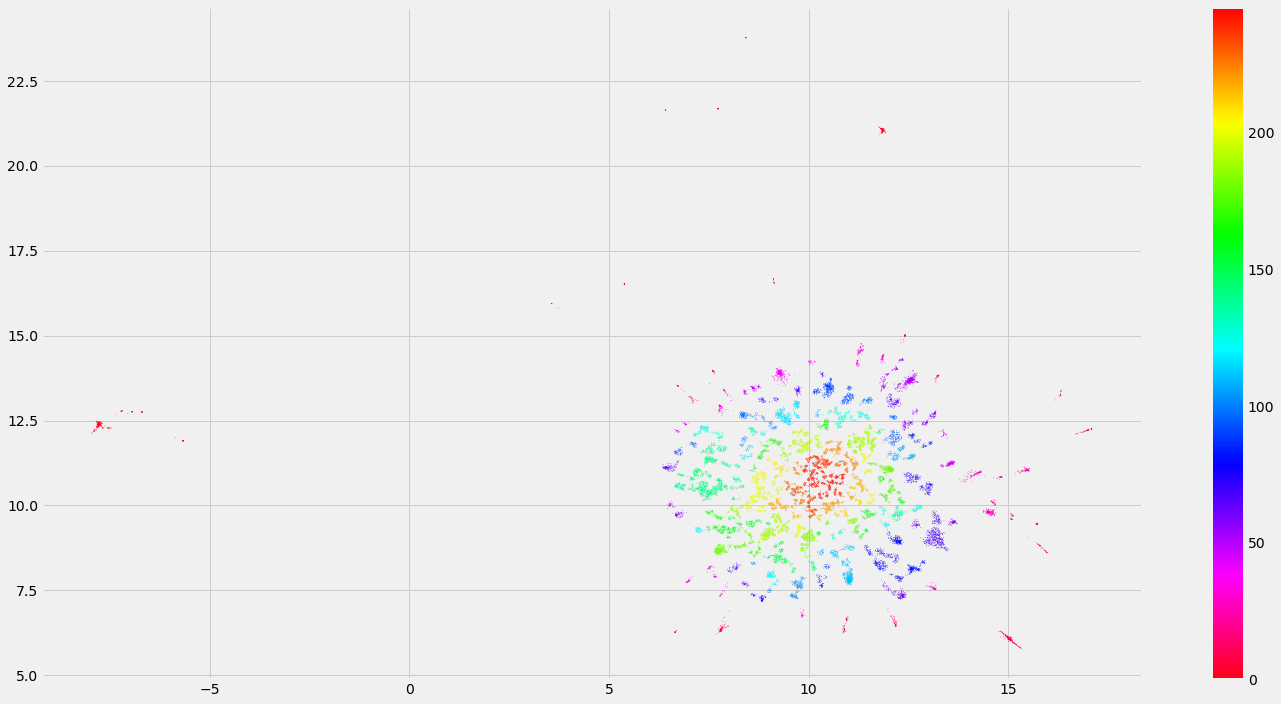

In [15]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
#plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()
plt.tight_layout()

In [16]:
px.scatter(x=clustered.x, y=clustered.y, color=clustered.labels, color_discrete_map='hsv_r')

In [17]:
indexes = result.loc[result.loc[:, "labels"]==178].index.values

In [18]:
print(list(feature_names[indexes]))

['#blaadk', '#danmarksradio', '#europadagen', '#frækt', '#fyforsatan', '#grønneresunderesjovere', '#internationalsafeabortionday', '#mongoartic', '#musikudvalget', '#unge', '0,00013', '109', '16.november', '3rd', '88.500', '@bachsune', '@danjorgensen', '@dkpolitik', '@frejalockenwitz', '@kooperationendk', '@lixen_sdu', '@louiseklinge', '@lrforlag', '@mshakespearek', '@nwf', '@rasmustantholdt', '@rosalund', '@stueyphooey', '@u2comzoomods', '@vandcenter_syd', ']=', '_7002', 'absorbed', 'administrative', 'afdragsmodel', 'afghangerne', 'afhghanistan', 'aktiegevinst', 'albaqara', 'andelsboliger', 'arbejdsret', 'arbejdstilsyn', 'awarding', 'batterisera', 'betegnet', 'bilhusene', 'blog', 'blokeret', 'blower', 'blågård', 'bms', 'bobbel', 'bog', 'boligformerne', 'boligpolitisk', 'boligudspillet', 'boligudstillingen', 'books', 'brandbeskattes', 'brystet', 'brøler-cv', 'campere', 'cykel-udlejere', 'deciding', 'demokrati-garage', 'doesnt', 'dommermangel', 'drikkevarer', 'elevatoren', 'em-bronze', 

# Clustering with k-means

In [19]:
from sklearn.cluster import MiniBatchKMeans

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 22 clusters
Fit 24 clusters
Fit 26 clusters
Fit 28 clusters
Fit 30 clusters
Fit 32 clusters
Fit 34 clusters
Fit 36 clusters
Fit 38 clusters
Fit 40 clusters
Fit 42 clusters
Fit 44 clusters
Fit 46 clusters
Fit 48 clusters
Fit 50 clusters


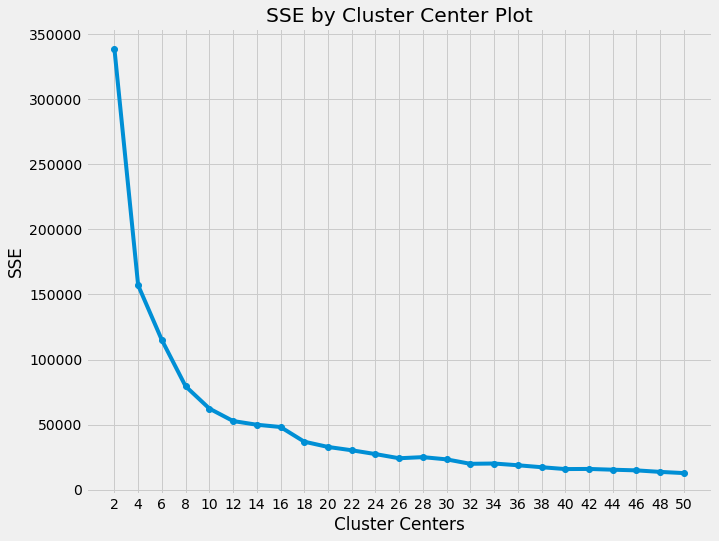

In [20]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(umap_embeddings, 50)

In [21]:
clusters = MiniBatchKMeans(n_clusters=40, init_size=1024, batch_size=2048, random_state=20).fit_predict(umap_embeddings)

In [22]:
np.unique(clusters)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39], dtype=int32)

In [23]:
result = pd.DataFrame(umap_embeddings, columns=['x', 'y'])
result['labels'] = clusters

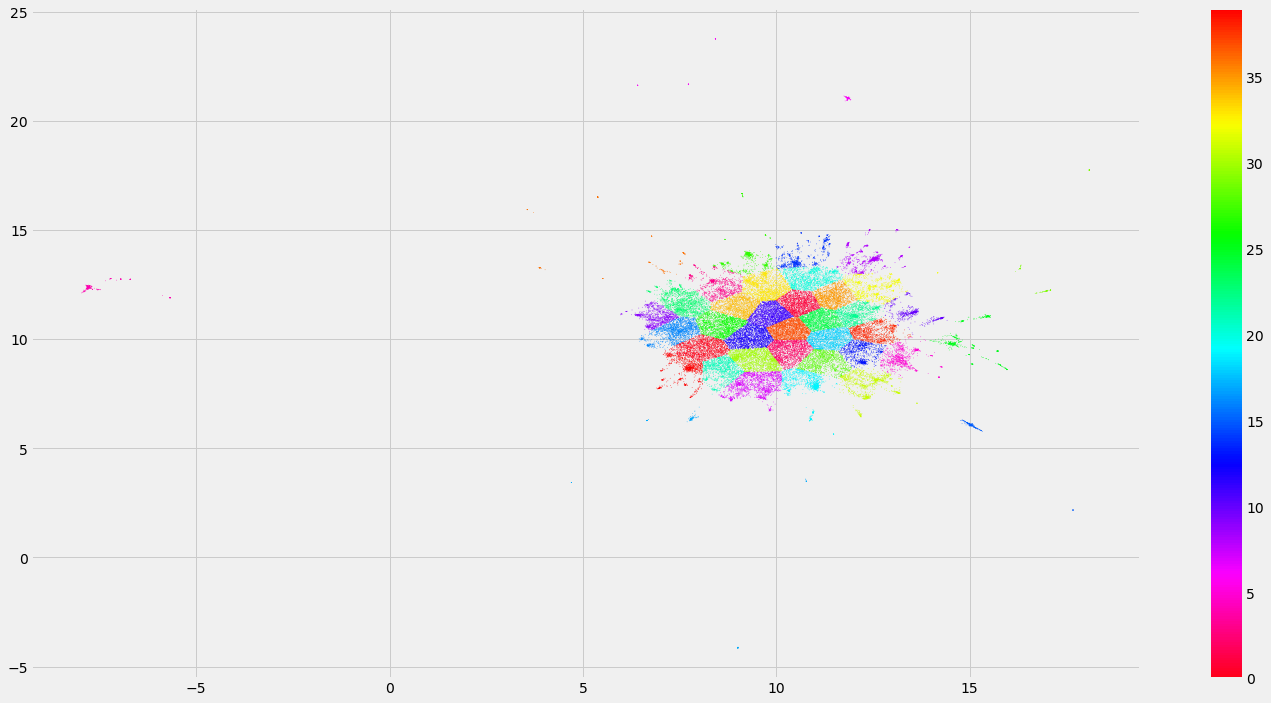

In [24]:
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
#plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()
plt.tight_layout()

In [25]:
indexes = result.loc[result.loc[:, "labels"]==1].index.values
print(list(feature_names[indexes]))

['##1428', '#911neverforget', '#aaa', '#aalborg', '#abortionishealthcare', '#aeldretopmoede', '#afghanistancrisis', '#afghanistanculture', '#americanpetroleum', '#animation', '#arbejdedk', '#arbejdsglæde', '#arcticcircle2021', '#assange', '#asylstop', '#axieinfinity', '#bahtoyunu', '#barmavegate', '#barnebrude', '#beccs', '#bekymrende', '#belgrade', '#beready', '#betalt', '#bevardimittendsatsen', '#bigbrother', '#bigoil', '#billigeboliger', '#bitcoinscam', '#blodpropsvaccinen', '#bolig', '#break', '#brobygger', '#browder', '#brøndby', '#bs', '#cardano', '#ccs', '#childabuse', '#christinestabellbenn', '#cirkus', '#co2indvandre', '#co2måler', '#co2udslip', '#compet', '#concito', '#coronakrisen', '#coronatosse', '#cykelkultur', '#dagpengereform', '#dansklandbrug', '#days', '#debat', '#decentrale', '#delebil', '#demokratiske', '#denlovgivendedenudøvendeogdendømmendemagt', '#denmarkinlebanon', '#dentists', '#detglobaleministerium', '#detgodebørneliv', '#dfkanikkelidekriminelle', '#dfsv2021'

In [26]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    print(df)
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(X[:100], clusters[:100], vectorizer.get_feature_names(), 10)

/home/carbon/.conda/envs/flow/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



     0      1      2      3      4      5      6      7      8      9      \
0   0.0000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1   0.0000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2   0.0000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3   0.0000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4   0.0000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5   0.0000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
7   0.0000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
8   0.2182    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
9   0.0000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
10  0.0000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
11  0.0000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
12  0.0000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

In [27]:
vectorizer.get_feature_names_out()

array(['', '\n', '\n\n.', ..., 'øøøhh', 'øøøhhh', 'øøøøh'], dtype=object)

In [28]:
np.unique(clusters)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39], dtype=int32)

In [29]:
pd.DataFrame(X.todense()[:1000]).groupby(clusters[:1000]).mean()

0      1      2      3      4      5      6      7      8      9      \
0   0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1   0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2   0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3   0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4   0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5   0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
7   0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
8   0.009092    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
9   0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
10  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
11  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
12  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
13  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
14  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
15  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
16  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
17  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
18  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
19  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
20  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
21  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
22  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
23  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
24  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
25  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
26  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
27  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
28  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
29  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
30  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
31  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
32  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
33  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
34  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
35  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
36  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
37  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
38  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
39  0.000000    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

    ...  89693  89694  89695  89696     89697  89698  89699  89700  89701  \
0   ...    0.0    0.0    0.0    0.0  0.000000    0.0    0.0    0.0    0.0   
1   ...    0.0    0.0    0.0    0.0  0.000000    0.0    0.0    0.0    0.0   
2   ...    0.0    0.0    0.0    0.0  0.000000    0.0    0.0    0.0    0.0   
3   ...    0.0    0.0    0.0    0.0  0.000000    0.0    0.0    0.0    0.0   
4   ...    0.0    0.0    0.0    0.0  0.000000    0.0    0.0    0.0    0.0   
5   ...    0.0    0.0    0.0    0.0  0.000000    0.0    0.0    0.0    0.0   
7   ...    0.0    0.0    0.0    0.0  0.000000    0.0    0.0    0.0    0.0   
8   ...    0.0    0.0    0.0    0.0  0.000000    0.0    0.0    0.0    0.0   
9   ...    0.0    0.0    0.0    0.0  0.000000    0.0    0.0    0.0    0.0   
10  ...    0.0    0.0    0.0    0.0  0.000000    0.0    0.0    0.0    0.0   